In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [2]:
# imports
import sys
sys.path.append('./utils')
from amg_utils import * 
import pickle
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import LightGBMModel, LinearRegressionModel, RegressionModel, XGBModel, CatBoostModel 
from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression

from darts.utils import missing_values
from darts.dataprocessing.transformers import StaticCovariatesTransformer

from sklearn.model_selection import train_test_split
from typing import List

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/opt/conda/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py3.11/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [5]:
## sql 

# fb_tonic_daily_perf_query = """   
   
#    select    
#    a.eventdate,
#    b.fb_created,  


#    a.buyer_initials,
#    a.buyer_name,
#    a.account_currency,
#    a.account_id,
#    a.account_name,
#    a.ad_id, 
#    a.ad_name,
#    a.adset_id,
#    a.adset_name,
#    a.campaign_id,
#    a.campaign_name,
#    --d.keyword, 
#    a.job_type,
#    COALESCE(a.fb_clicks_all, 0) as fb_clicks_all,
#    COALESCE(a.fb_impressions, 0) as fb_impressions,
#    COALESCE(a.fb_leads, 0) as fb_leads,
#    COALESCE(a.fb_link_click, 0) as fb_link_click,
#    a.fb_spend,
#    a.rev_clicks,
#    a.gross_revenue,
#    a.net_revenue,
#    a.fb_clicks_all / COALESCE(NULLIF(a.fb_impressions, 0), 1) as buy_side_ctr,
#    a.net_revenue / COALESCE(NULLIF(a.fb_spend, 0), 1) as roas,
#    a.net_revenue / COALESCE(NULLIF(a.fb_clicks_all, 0), 1) as rpc,
#    (a.fb_spend / COALESCE(NULLIF(a.fb_impressions, 0), 1))*1000 as buy_side_cpm,
#    a.fb_spend / COALESCE(NULLIF(a.fb_clicks_all, 0), 1) as cpc,
#    a.net_revenue / COALESCE(NULLIF(a.rev_clicks, 0), 1) as rpp,
#    a.fb_spend / COALESCE(NULLIF(a.rev_clicks, 0), 1) as cpp,
#    a.net_revenue - a.fb_spend as contrib, 
   
  
#    --b.end_time, 
#    b.budget,    
#    b.budget_type,   
#    b.status, 

#    c.devices,
#    c.countries,
#    c.network,
#    targeting_json:age_max::string AS age_max,
#    targeting_json:age_min::string AS age_min,
#    targeting_json:facebook_positions::string AS facebook_positions,
#    targeting_json:locales::string AS locales,
#    c.adset_schedule,   
#    c.lifetime_budget

#    from PRODUCTION.BD_S2CINTERNAL.v_cm_fb_tonic_daily_combine a 
#    left join SEM_TOOLS.cm_fb_campaign_management.ad_set_latest b on a.adset_id = b.id  and a.campaign_id = b.campaign_id and a.adset_name = b.name
#    left join PRODUCTION.BD_S2CINTERNAL.V_FACEBOOK_ADSET_METADATA c on a.adset_id = c.id and a.eventdate = c.event_date
#   -- left join PRODUCTION.BD_S2CINTERNAL.V_CM_TONIC_KEYWORD_DATA d on d.fb_campaign_name = a.campaign_name
#    where a.job_type= 'final'    
#      and a.buyer_initials = 'GN'   

#   order by  ad_id asc , eventdate asc  
#    """
# fb_tonic_daily_perf = eq(fb_tonic_daily_perf_query)

In [3]:
# load data

# fb_tonic_daily_perf = pd.read_csv("fb_tonic_daily_perf_query.csv", index_col=0, parse_dates=['eventdate'])

# # Crate campaign duration in days variable
# fb_tonic_daily_perf.insert(2, 'campaign_duration', fb_tonic_daily_perf.groupby('campaign_id')['eventdate'].transform(lambda x: (x.max() - x.min()).days))

# # Create campaign end date variable
# fb_tonic_daily_perf.insert(2, 'campaign_end_date', fb_tonic_daily_perf.groupby('campaign_id')['eventdate'].transform("max"))

# # Filter out campaigns with less than {min_campaign_duration} days duration
min_campaign_duration = 4 
# series = fb_tonic_daily_perf[fb_tonic_daily_perf['campaign_duration'] > 4].copy()
# series.ad_id = series.ad_id.astype('str')

# static_cols = [      
# "network",
# "devices"]     

# def one_hot_encode(df, cols):
#     encoded = pd.get_dummies(df[cols])
#     df = df.drop(columns=cols, axis=1)
#     df = pd.concat([df, encoded], axis=1)
#     return df

# series =  one_hot_encode(series, static_cols)

series = pd.read_csv('series.csv', index_col=0, parse_dates=['eventdate'], dtype={'ad_id': str})

In [5]:
## stats 

dataset = "gn_fb_tonic"
print(f"Dataset: {dataset}")
# Total number of campaigns
print(f"Total number of campaigns: {series.ad_id.nunique()}")
# Ads starting from date ... 
print(f"Min eventdate: {series.eventdate.min().date()}") 
print(f"Max eventdate: {series.eventdate.max().date()}")
days_between = (series.eventdate.max().date() - series.eventdate.min().date()).days
print(f"Days between min and max eventdate: {days_between}")
print()
# Duration of campaigns 
campaign_duration_count = series.groupby(["ad_id", "campaign_duration"]).size().value_counts().sort_index().reset_index(name='count').rename(columns={'index':'campaign_duration (days)'})
print(f"Duration of campaigns (filtered to only campaigns of {min_campaign_duration} or more days): \n{campaign_duration_count}")
print()
# mean campaign duration 
print(f"Mean campaign duration: {series.campaign_duration.mean().round(1)} days")

series['fb_created_date'] = pd.to_datetime(series['fb_created']).dt.date
print()

# number of unique ad_ids per date 
campaigns_created_per_date = series.groupby('fb_created_date').ad_id.nunique().reset_index(name='count').sort_values('fb_created_date', ascending=True)
print(f"Number of campaigns created per date: \n {campaigns_created_per_date}")
positive_contrib_ads = series.groupby('ad_id')['contrib'].sum().reset_index()
print()
positive_contrib_ads = positive_contrib_ads[positive_contrib_ads['contrib'] > 0]['ad_id']
print(f"Number of campaigns with positive contribution: \n {positive_contrib_ads.nunique()}")
# print(positive_contrib_ads)
# peek(series[series['ad_id'].isin(positive_contrib_ads[positive_contrib_ads['contrib'] > 0]['ad_id'])])

# peek(series[series['ad_id'] == '120204217187110410'])


# TODO

# extended campaings 


Dataset: gn_fb_tonic
Total number of campaigns: 146
Min eventdate: 2024-01-17
Max eventdate: 2024-02-13
Days between min and max eventdate: 27

Duration of campaigns (filtered to only campaigns of 4 or more days): 
   campaign_duration (days)  count
0                         5      3
1                         6     16
2                         7     42
3                         8     71
4                         9      9
5                        10      2
6                        15      1
7                        16      1
8                        21      1

Mean campaign duration: 7.2 days

Number of campaigns created per date: 
   fb_created_date  count
0      2024-01-18      9
1      2024-01-19     13
2      2024-01-24     39
3      2024-01-25     24
4      2024-01-26     22
5      2024-01-30     39

Number of campaigns with positive contribution: 
 3


In [4]:
# train/val split 

unique_ad_ids = series['ad_id'].unique()

train_ad_ids, val_ad_ids = train_test_split(unique_ad_ids, test_size=0.3, random_state=42)

train = series[series['ad_id'].isin(train_ad_ids)]
val = series[series['ad_id'].isin(val_ad_ids)]

print(f"train: {(train['ad_id'].nunique()/series['ad_id'].nunique())}")
print(f"val: {val['ad_id'].nunique()/series['ad_id'].nunique()}")

print(f"train ads: {train.ad_id.nunique()}")
print(f"val ads: {val.ad_id.nunique()}")


train: 0.6986301369863014
val: 0.3013698630136986
train ads: 102
val ads: 44


In [5]:
# set up timeseries for darts 

time_col = 'eventdate'
group_cols = 'ad_id'
static_cols = ['age_max',
               'age_min',  
                'network_["facebook","instagram"]',   
                'network_["facebook"]',
                'devices_["mobile","desktop"]',
                'devices_["mobile"]'
                ]

# value_col = ['net_revenue', 'fb_spend']

value_col = "roas"

past_covariates = ['fb_spend', 
                   'fb_clicks_all',
                   'fb_impressions',
                   'fb_leads',
                   'rev_clicks',
                   'fb_link_click',                
                   ]

# future_covariates = ["campaign_duration"]


train_ts = TimeSeries.from_group_dataframe(
                            train,
                            time_col= time_col,
                            group_cols= group_cols,
                            static_cols= static_cols,
                            value_cols= value_col ,
                            fill_missing_dates=True,                            
                            freq='D')


val_ts = TimeSeries.from_group_dataframe(
                            val,
                            time_col= time_col,
                            group_cols= group_cols,
                            static_cols= static_cols,
                            value_cols= value_col ,
                            fill_missing_dates=True,                            
                            freq='D')


past_covariates_ts = TimeSeries.from_group_dataframe(
    train,
    time_col=time_col,    
    group_cols=group_cols,
    static_cols= static_cols,
    value_cols=past_covariates,
    freq='D'  
)


past_covariates_vs = TimeSeries.from_group_dataframe(
    val,
    time_col=time_col,
    group_cols=group_cols,
     static_cols= static_cols,
    value_cols=past_covariates,
    freq='D'  
)


# fill missing values darts 

for i, ts in enumerate(train_ts):    
    if not ts.gaps().empty:        
        train_ts[i] = missing_values.fill_missing_values(ts)

for i, ts in enumerate(val_ts):    
    if not ts.gaps().empty:        
        val_ts[i] = missing_values.fill_missing_values(ts)
        
for i, ts in enumerate(past_covariates_ts):    
    if not ts.gaps().empty:        
        past_covariates_ts[i] = missing_values.fill_missing_values(ts)

for i, ts in enumerate(past_covariates_vs):    
    if not ts.gaps().empty:        
        past_covariates_vs[i] = missing_values.fill_missing_values(ts)



transformer = StaticCovariatesTransformer()
train_ts = transformer.fit_transform(train_ts)
val_ts = transformer.fit_transform(val_ts)
past_covariates_ts = transformer.fit_transform(past_covariates_ts)       
past_covariates_vs = transformer.fit_transform(past_covariates_vs)       

In [ ]:
## check missing values in timeseries

# for i, ts in enumerate(past_covariates_ts):
#     dataframe = ts.pd_dataframe()  # Convert each TimeSeries to a DataFrame
#     has_nans = dataframe.isna().values.any()  # Check for NaN values
#     print(f"TimeSeries {i} contains NaN values? {has_nans}")
# nan_series = [dataframe.isna().any().any() for dataframe in [ts.pd_dataframe() for ts in all_campaigns_ts]]


In [6]:
with open("experiment_params.yaml", 'r') as stream:
    try:
        experiment_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [7]:
def eval_global_model(
    train_ts: List[TimeSeries],    
    val_ts: List[TimeSeries],
    val:pd.DataFrame,
    model_cls,     
    past_covariates_ts: List[TimeSeries],
    past_covariates_vs: List[TimeSeries],    
    model_params: dict,
    forecast_params: dict,  
   

) -> pd.DataFrame:

    
    model = model_cls(**model_params)

    if model_params.get("lags_past_covariates") is not None:
        model.fit(train_ts, past_covariates_ts)
    else:
        model.fit(train_ts)        
    
    backtest = model.historical_forecasts(
                series = val_ts,
                past_covariates = past_covariates_vs,                
               **forecast_params
               )
    
    unique_ad_ids = val['ad_id'].unique()
    positions_df = pd.DataFrame({'ad_id': unique_ad_ids, 'position': range(len(unique_ad_ids))})

    df = pd.DataFrame()

    for i, series in enumerate(backtest):
        backtest_ad_id = positions_df.iloc[i]['ad_id']
        # Convert the TimeSeries object to a DataFrame
        forecast_df = series.pd_dataframe().rename(columns={'roas': 'roas_forecasted'})
        
        # Merge the actual values with the forecasted values
        temp_df = pd.merge(val[val['ad_id'] == backtest_ad_id].sort_values(by='eventdate')[['ad_id', 'eventdate', 'roas']].rename(columns={'roas': 'roas_actual'}),
                        forecast_df, left_on='eventdate', right_index=True, how='left')
        
        # Calculate cumulative sums and residuals
        temp_df['roas_act_cum'] = temp_df['roas_actual'].cumsum()
        temp_df['roas_fcst_cum'] = temp_df['roas_forecasted'].cumsum()
        temp_df['residuals'] = temp_df['roas_forecasted'] - temp_df['roas_actual']
        
        # Add model information
        if model.__class__.__name__ == 'RegressionModel':
            temp_df['model'] = model.model.__class__.__name__
        else:
            temp_df['model'] = model.__class__.__name__
        temp_df['params'] = temp_df.apply(lambda x: {'model_params': model_params, 'forecast_params': forecast_params}, axis=1)
        
        # Append the results to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)

    return df, backtest

In [8]:
def make_forecast_plots(val_ts, backtest):
    
    num_plots = len(val_ts)
    num_cols = 4
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows*5))
    for i, ax in enumerate(axs.flatten()):
        if i < num_plots:
            val_ts[i].plot(ax=ax, label='Actual ROAS')        
            backtest[i].plot(ax=ax, label='Forecasted ROAS')            
            ax.legend()
        else:
            ax.axis('off')
    # plt.tight_layout()
    # plt.show()
    return fig    


In [9]:
def perf_per_ad(
    forecast: pd.DataFrame):
    grouped = forecast.groupby('ad_id').agg(
        # contrib=('roas_actual', 'sum'),
        # predicted_contrib=('roas_forecasted', 'sum'),
        cumulative_roas_actual=('roas_act_cum', 'last'),
        cumulative_roas_predicted=('roas_fcst_cum', 'last'),
        MAE=('residuals', lambda x: (x.abs()).mean()),
        RMSE=('residuals', lambda x: ((x**2).mean())**0.5)
    ).reset_index()
    grouped.columns = [
        'ad_id', 
        # 'contrib', 
        # 'predicted_contrib', 
        'cumulative_roas_actual', 'cumulative_roas_predicted', 'MAE', 'RMSE']
    return grouped

In [10]:
model_list = [

    # ("linear_reg", LinearRegressionModel),
    ("lgbm", LightGBMModel),
    # ("ridge",Ridge),
    # ("bayes_ridge", BayesianRidge),
    # ("xgboost",XGBModel),
    # ("catboost", "CatBoostModel")
]

In [ ]:
# shap 

In [40]:
def run_experiments(
    model_list,    
    train_ts: List[TimeSeries],    
    val_ts: List[TimeSeries],
    val: pd.DataFrame,     
    past_covariates_ts: List[TimeSeries],
    past_covariates_vs: List[TimeSeries],    
    experiment_params: dict,
    forecast_params: dict,  
):
    results_forecasts_dict = {}
    
    for model_name, model_class in model_list:   
        for i,v in experiment_params.items():  
            if i == "model_params":
                params_to_use = v 
            else:          
                params_to_use = v['model_params']             

            if model_class in [Ridge, BayesianRidge,LinearRegressionModel]: 
                for key in ["categorical_static_covariates", "verbose", "likelihood", "quantiles", "random_state"]:
                    params_to_use.pop(key, None)
            if model_class in [Ridge, BayesianRidge]: 
                # nested_model = 
                model = RegressionModel
                # model = RegressionModel(model=model_class(), **params_to_use)
                params_to_use['model'] = model_class()
            else:
                model = model_class
            
            forecast, backtest = eval_global_model(
                train_ts,    
                val_ts,
                val,
                model, 
                past_covariates_ts,
                past_covariates_vs,    
                params_to_use,
                forecast_params
            )
            
            
            forecast.to_csv(f"exp_results/{model_name}_{i}_forecast.csv")
            perf_per_ad(forecast).to_csv(f"exp_results/{model_name}_{i}_results_per_ad.csv")
            with open(f"exp_results/{model_name}_{i}_backtest.pkl", 'wb') as f:
                pickle.dump(backtest, f)

            results_forecasts_dict[f"{model_name}_forecast"] = forecast
            results_forecasts_dict[f"{model_name}_backtest"] = backtest
            

            fig = make_forecast_plots(val_ts, backtest);      

            fig.savefig(f"exp_results/{model_name}_{i}_backtest.png");

    return results_forecasts_dict

In [44]:
import os

def run_experiments(
    model_list,    
    train_ts: List[TimeSeries],    
    val_ts: List[TimeSeries],
    val: pd.DataFrame,     
    past_covariates_ts: List[TimeSeries],
    past_covariates_vs: List[TimeSeries],    
    experiment_params: dict or list,
    forecast_params: dict,  
):
    results_forecasts_dict = {}
    
    # Ensure experiment_params is a list to handle both single and multiple parameter sets
    if isinstance(experiment_params, dict):
        experiment_params = [experiment_params]
    
    # Check if the exp_results folder exists, if not, create it
    results_dir = "exp_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    for model_name, model_class in model_list:   
        for params_set in experiment_params:
            params_to_use = params_set.get('model_params', {})            

            if model_class in [Ridge, BayesianRidge, LinearRegressionModel]: 
                for key in ["categorical_static_covariates", "verbose", "likelihood", "quantiles", "random_state"]:
                    params_to_use.pop(key, None)
            if model_class in [Ridge, BayesianRidge]: 
                model = RegressionModel
                params_to_use['model'] = model_class()
            else:
                model = model_class
            
            forecast, backtest = eval_global_model(
                train_ts,    
                val_ts,
                val,
                model, 
                past_covariates_ts,
                past_covariates_vs,    
                params_to_use,
                forecast_params
            )
            
            # Generate filenames based on model name and parameters set index
            params_set_name = f"params_{experiment_params.index(params_set) + 1}"
            forecast.to_csv(f"{results_dir}/{model_name}_{params_set_name}_forecast.csv")
            perf_per_ad(forecast).to_csv(f"{results_dir}/{model_name}_{params_set_name}_results_per_ad.csv")
            with open(f"{results_dir}/{model_name}_{params_set_name}_backtest.pkl", 'wb') as f:
                pickle.dump(backtest, f)

            results_forecasts_dict[f"{model_name}_{params_set_name}_forecast"] = forecast
            results_forecasts_dict[f"{model_name}_{params_set_name}_backtest"] = backtest
            
            fig = make_forecast_plots(val_ts, backtest)
            fig.savefig(f"{results_dir}/{model_name}_{params_set_name}_backtest.png")

    return results_forecasts_dict

In [13]:
import os

def run_experiments(
    model_list,    
    train_ts: List[TimeSeries],    
    val_ts: List[TimeSeries],
    val: pd.DataFrame,     
    past_covariates_ts: List[TimeSeries],
    past_covariates_vs: List[TimeSeries],    
    experiment_params: dict or list,
):
    results_forecasts_dict = {}
    
    # Ensure experiment_params is a list to handle both single and multiple parameter sets
    if isinstance(experiment_params, dict):
        experiment_params = [experiment_params]
    
    # Check if the exp_results folder exists, if not, create it
    results_dir = "exp_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    for model_name, model_class in model_list:   
        for params_set in experiment_params:
            model_params = params_set.get('model_params', {})
            forecast_params = params_set.get('forecast_params', {})

            if model_class in [Ridge, BayesianRidge, LinearRegressionModel]: 
                for key in ["categorical_static_covariates", "verbose", "likelihood", "quantiles", "random_state"]:
                    model_params.pop(key, None)
            if model_class in [Ridge, BayesianRidge]: 
                model = RegressionModel
                model_params['model'] = model_class()
            else:
                model = model_class
            
            forecast, backtest = eval_global_model(
                train_ts,    
                val_ts,
                val,
                model, 
                past_covariates_ts,
                past_covariates_vs,    
                model_params,
                forecast_params
            )
            
            # Generate filenames based on model name and parameters set index
            params_set_name = f"params_{experiment_params.index(params_set) + 1}"
            forecast.to_csv(f"{results_dir}/{model_name}_{params_set_name}_forecast.csv")
            perf_per_ad(forecast).to_csv(f"{results_dir}/{model_name}_{params_set_name}_results_per_ad.csv")
            with open(f"{results_dir}/{model_name}_{params_set_name}_backtest.pkl", 'wb') as f:
                pickle.dump(backtest, f)

            results_forecasts_dict[f"{model_name}_{params_set_name}_forecast"] = forecast
            results_forecasts_dict[f"{model_name}_{params_set_name}_backtest"] = backtest
            
            fig = make_forecast_plots(val_ts, backtest)
            fig.savefig(f"{results_dir}/{model_name}_{params_set_name}_backtest.png")
            plt.close(fig)

      

    return results_forecasts_dict

In [11]:
import os
from darts.metrics import mae, rmse
import numpy as np
import pandas as pd

def calculate_metrics_and_create_df(val_ts, backtest, model_params):
    rmse_values = [rmse(val_ts[i], backtest[i]) for i in range(len(val_ts))]
    mae_values = [mae(val_ts[i], backtest[i]) for i in range(len(val_ts))]

    # Calculate metrics
    average_rmse = np.mean(rmse_values)
    median_rmse = np.median(rmse_values)
    std_rmse = np.std(rmse_values)
    average_mae = np.mean(mae_values)
    median_mae = np.median(mae_values)
    std_mae = np.std(mae_values)

    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Model Params': [model_params],
        'MAE': [average_mae],
        'RMSE': [average_rmse],
        'Median MAE': [median_mae],
        'Median RMSE': [median_rmse],
        'Std MAE': [std_mae],
        'Std RMSE': [std_rmse]
    })

    return metrics_df

def run_experiments(
    model_list,    
    train_ts: List[TimeSeries],    
    val_ts: List[TimeSeries],
    val: pd.DataFrame,     
    past_covariates_ts: List[TimeSeries],
    past_covariates_vs: List[TimeSeries],    
    experiment_params: dict or list,
):
    results_forecasts_dict = {}
    metrics_df = pd.DataFrame()  # Initialize an empty DataFrame to store metrics
    
    # Ensure experiment_params is a list to handle both single and multiple parameter sets
    if isinstance(experiment_params, dict):
        experiment_params = [experiment_params]
    
    # Check if the exp_results folder exists, if not, create it
    results_dir = "exp_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    for model_name, model_class in model_list:   
        for params_set in experiment_params:
            model_params = params_set.get('model_params', {})
            forecast_params = params_set.get('forecast_params', {})

            if model_class in [Ridge, BayesianRidge, LinearRegressionModel]: 
                for key in ["categorical_static_covariates", "verbose", "likelihood", "quantiles", "random_state"]:
                    model_params.pop(key, None)
            if model_class in [Ridge, BayesianRidge]: 
                model = RegressionModel
                model_params['model'] = model_class()
            else:
                model = model_class
            
            forecast, backtest = eval_global_model(
                train_ts,    
                val_ts,
                val,
                model, 
                past_covariates_ts,
                past_covariates_vs,    
                model_params,
                forecast_params
            )
            
            # Generate filenames based on model name and parameters set index
            params_set_name = f"params_{experiment_params.index(params_set) + 1}"
            forecast.to_csv(f"{results_dir}/{model_name}_{params_set_name}_forecast.csv")
            perf_per_ad(forecast).to_csv(f"{results_dir}/{model_name}_{params_set_name}_results_per_ad.csv")
            with open(f"{results_dir}/{model_name}_{params_set_name}_backtest.pkl", 'wb') as f:
                pickle.dump(backtest, f)

            results_forecasts_dict[f"{model_name}_{params_set_name}_forecast"] = forecast
            results_forecasts_dict[f"{model_name}_{params_set_name}_backtest"] = backtest
            
            fig = make_forecast_plots(val_ts, backtest)
            fig.savefig(f"{results_dir}/{model_name}_{params_set_name}_backtest.png")

            # Calculate metrics and append to the metrics DataFrame
            temp_metrics_df = calculate_metrics_and_create_df(val_ts, backtest, model_params)
            temp_metrics_df['Model Name'] = model_name
            temp_metrics_df['Params Set Name'] = params_set_name
            metrics_df = pd.concat([metrics_df, temp_metrics_df], ignore_index=True)
            plt.close(fig)


    return results_forecasts_dict, metrics_df

In [15]:
model_params = {
    "lags": list(range(-1, 0)),
    "output_chunk_length": 1,
    "lags_past_covariates": list(range(-1, 0)),
    # "likelihood": "quantile",
    # "quantiles": [0.05, 0.5, 0.95],
    "multi_models": True,
    "random_state": 42,
    "use_static_covariates": True,
    "categorical_static_covariates": static_cols,
    'verbose': -1,
    # "device": "cuda"
}

forecast_params = {
    # "start": 0.7,  
    "forecast_horizon": 1,
    # "stride": 3,  
    "predict_likelihood_parameters": False,
    # "num_samples": 50,  
    "retrain": False,
    "verbose": False
}

In [14]:
results_forecasts_dict, metrics_df = run_experiments(
    model_list,
    train_ts,
    val_ts,
    val,
    past_covariates_ts,
    past_covariates_vs,
    experiment_params['params_1'],
    )

ValueError: Some `categorical_static_covariates` components ({'static_cols'}) declared at model creation are not present in the series' `static_covariates` passed to the `fit()` call.


ValueError: Some `categorical_static_covariates` components ({'static_cols'}) declared at model creation are not present in the series' `static_covariates` passed to the `fit()` call.

In [62]:
metrics_df

,Model Params,MAE,RMSE,Median MAE,Median RMSE,Std MAE,Std RMSE,Model Name,Params Set Name
0,"{'lags': [-1], 'output_chunk_length': 1, 'lags...",0.24121,0.290345,0.21247,0.250405,0.098276,0.133131,bayes_ridge,params_1


In [52]:
results_forecasts_dict.keys()

dict_keys(['bayes_ridge_params_1_forecast', 'bayes_ridge_params_1_backtest'])

In [1]:
results_forecasts_dict["bayes_ridge_params_1_backtest"]

NameError: name 'results_forecasts_dict' is not defined

In [55]:
from darts.metrics import rmse

In [56]:
# backtest rmse

rmse_values = [rmse(val_ts[i], results_forecasts_dict["bayes_ridge_params_1_backtest"][i]) for i in range(len(val_ts))]

# Calculate the average RMSE across all campaigns
average_rmse = np.mean(rmse_values)
print('Average Backtest RMSE = {}'.format(np.round(average_rmse, 2)))

median_rmse = np.median(rmse_values)
std_rmse = np.std(rmse_values)
print('Median Backtest RMSE = {}'.format(np.round(median_rmse, 2)))
print('Standard Deviation of Backtest RMSE = {}'.format(np.round(std_rmse, 2)))

Average Backtest RMSE = 0.29
Median Backtest RMSE = 0.25
Standard Deviation of Backtest RMSE = 0.13


In [57]:

def calculate_metrics_and_create_df(val_ts, backtest, model_params):
    rmse_values = [rmse(val_ts[i], backtest[i]) for i in range(len(val_ts))]
    mae_values = [mae(val_ts[i], backtest[i]) for i in range(len(val_ts))]

    # Calculate metrics
    average_rmse = np.mean(rmse_values)
    median_rmse = np.median(rmse_values)
    std_rmse = np.std(rmse_values)
    average_mae = np.mean(mae_values)
    median_mae = np.median(mae_values)
    std_mae = np.std(mae_values)

    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Model Params': [model_params],
        'MAE': [average_mae],
        'RMSE': [average_rmse],
        'Median MAE': [median_mae],
        'Median RMSE': [median_rmse],
        'Std MAE': [std_mae],
        'Std RMSE': [std_rmse]
    })

    return metrics_df

In [261]:
# lgbm_forecast, lgbm_backtest = eval_global_model(
#     train_ts,    
#     val_ts,
#     val,
#     XGBModel,     
#     past_covariates_ts,
#     past_covariates_vs,    
#     model_params,
#     forecast_params
# )

In [259]:
# linear_reg_forecast, linear_reg_backtest = eval_global_model(
#     train_ts,    
#     val_ts,
#     val,
#     LinearRegressionModel,     
#     past_covariates_ts,
#     past_covariates_vs,    
#     model_params,
#     forecast_params
# )

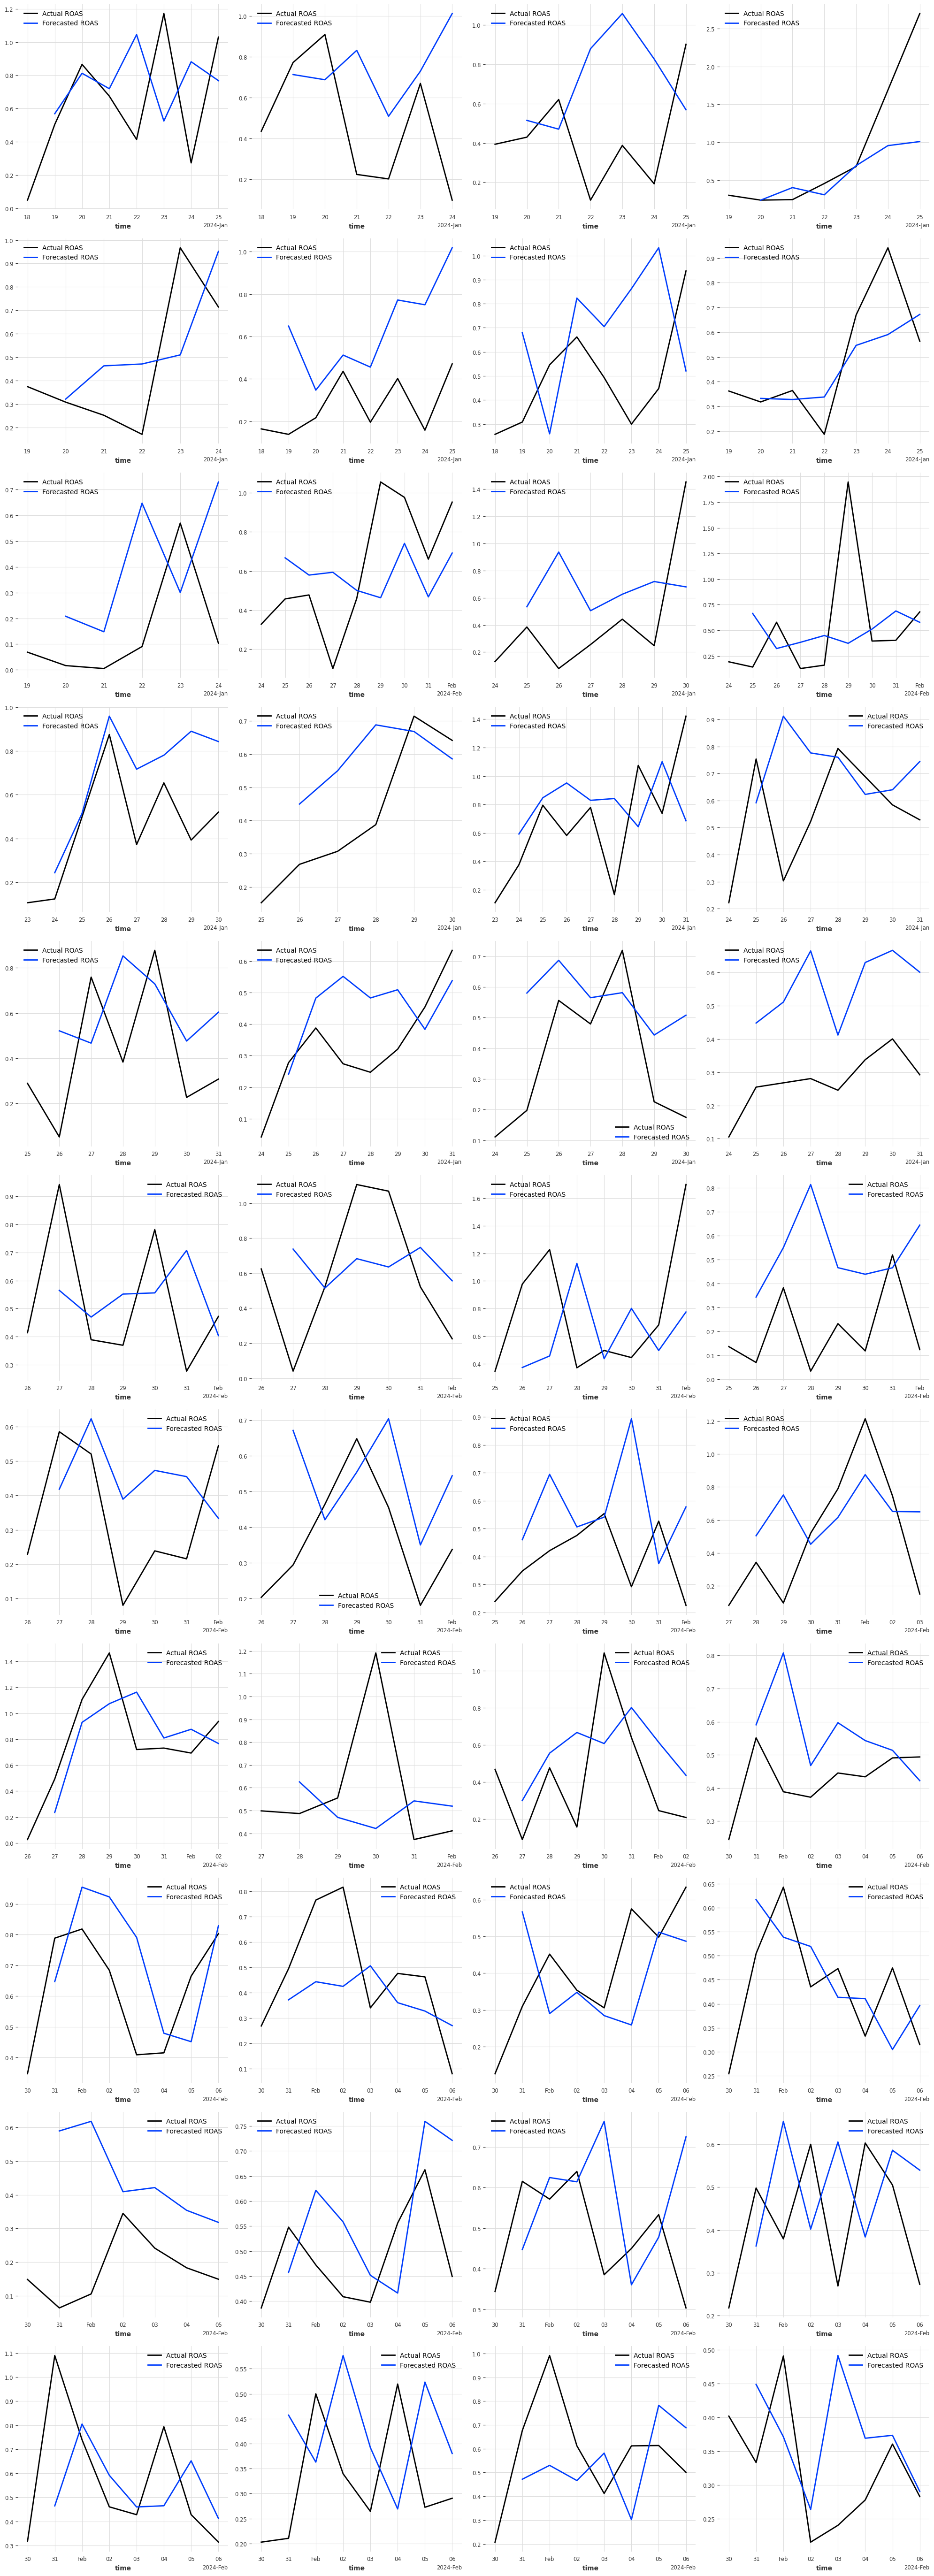

In [262]:
# plot backtest vs revenue

num_plots = len(val_ts)
num_cols = 4
num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows*5))
for i, ax in enumerate(axs.flatten()):
    if i < num_plots:
        val_ts[i].plot(ax=ax, label='Actual ROAS')        
        lgbm_backtest[i].plot(ax=ax, label='Forecasted ROAS')
        # backtest[i]['fb_spend'].plot(ax=ax, label='Forecasted FB Spend')
        ax.legend()
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# fig.savefig("backtest_vs_revenue.png")


In [ ]:
# get plots for each model and each parameter combination and save them 
# produce summary tables of model performance and parameter combinations
# shap 

In [63]:
from darts.explainability.shap_explainer import ShapExplainer

Support for Torch based explainers not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


In [65]:
model = LightGBMModel(
                lags= list(range(-1, 0)),
                # past_covariates = past_covariates_ts,
                output_chunk_length = 1,
                lags_past_covariates= list(range(-1, 0)),
                likelihood="quantile", quantiles=[0.05, 0.5, 0.95],                    
                multi_models= True,
                random_state=42,                    
                use_static_covariates = True,  
                categorical_static_covariates = static_cols                 
                # device = "cuda"                    
                    )

In [67]:
model.fit(train_ts, 
          past_covariates= past_covariates_ts,          
          )
          

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 13
[LightGBM] [Info] Start training from score 0.142091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LightGBMModel(lags=[-1], lags_past_covariates=[-1], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.5, 0.95], random_state=42, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=['age_max', 'age_min', 'network_["facebook","instagram"]', 'network_["facebook"]', 'devices_["mobile","desktop"]', 'devices_["mobile"]'])

In [104]:
shap_explain = ShapExplainer(model)
# results = shap_explain.explain()
shap_explain.summary_plot()
# shap_explain.force_plot_from_ts()

ValueError: `background_series` must be provided `model` was fit on multiple time series.


ValueError: `background_series` must be provided `model` was fit on multiple time series.

In [ ]:
# explain() generates the explanations for a given foreground series (or background series, if foreground is not provided).

# summary_plot() displays a shap plot summary for each horizon and each component dimension of the target series.

# force_plot_from_ts() displays a shap force_plot for one target and one horizon, for a given target series. It displays shap values of each lag/covariate with an additive force

In [70]:
import shap

In [125]:
shap_explain = ShapExplainer(model, train_ts, past_covariates_ts)
shap_fig = shap_explain.summary_plot

The model is probabilistic, but num_samples=1 will be used for explainability.


In [130]:
import darts

In [131]:
from darts.explainability.shap_explainer import ShapExplainer

In [142]:
shap_explain = ShapExplainer(model, train_ts, past_covariates_ts)
fig=plt.gcf()
shap_explain.summary_plot(show=False,)
fig.savefig('scratch.png')
# import matplotlib.pyplot as plt
plt.close('all')

The model is probabilistic, but num_samples=1 will be used for explainability.


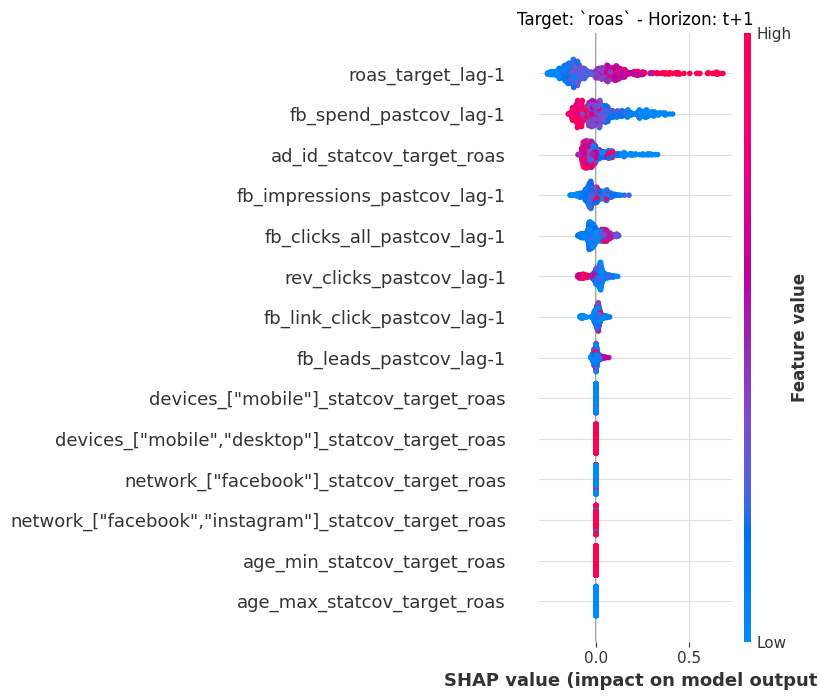

{1: {'roas': .values =
  array([[ 0.12696651,  0.23036091, -0.01377101, ...,  0.        ,
           0.        ,  0.        ],
         [-0.1915146 ,  0.31248105, -0.01649109, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.11875986,  0.29635447, -0.0052156 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.12229053, -0.10364328,  0.00414614, ...,  0.        ,
           0.        ,  0.        ],
         [-0.14484589, -0.09346182, -0.02379531, ...,  0.        ,
           0.        ,  0.        ],
         [-0.12309172,  0.0375565 ,  0.00146221, ...,  0.        ,
           0.        ,  0.        ]])
  
  .base_values =
  array([0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.9197197

In [133]:
shap_fig()

In [129]:
import matplotlib.pyplot as plt
import shap

# Assuming shap_explain and shap_values are already defined
shap_values = shap_explain.explain()

# Generate the SHAP summary plot
shap.summary_plot(shap_values, show=False)  # Set show=False to prevent immediate display

# Save the currently active matplotlib figure
plt.savefig("shap_summary_plot.png")

AttributeError: 'ShapExplainabilityResult' object has no attribute 'shape'

In [94]:
results.get_explanation(horizon=1)

[<TimeSeries (DataArray) (time: 9, component: 14, sample: 1)> Size: 1kB
 array([[[ 1.26966509e-01],
         [ 2.30360914e-01],
         [-1.37710144e-02],
         [ 6.13617528e-02],
         [ 1.25191072e-03],
         [ 7.65323491e-02],
         [ 5.34426560e-02],
         [ 2.85949011e-01],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],
 
        [[-1.91514604e-01],
         [ 3.12481050e-01],
         [-1.64910860e-02],
         [-4.22185919e-02],
         [ 7.23262432e-04],
 ...
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],
 
        [[ 6.97832520e-02],
         [ 3.41022724e-01],
         [-8.58283555e-03],
         [ 7.53780880e-02],
         [ 1.38668317e-02],
         [ 6.00658500e-03],
         [ 3.90463686e-02],
         [ 2.73127020e-01],
         [ 0.00000000

In [99]:
shap_explain = shap.Explainer(model, train_ts, past_covariates_ts)
# shap_values = shap_explain(train_ts)

TypeError: The passed link function needs to be callable!

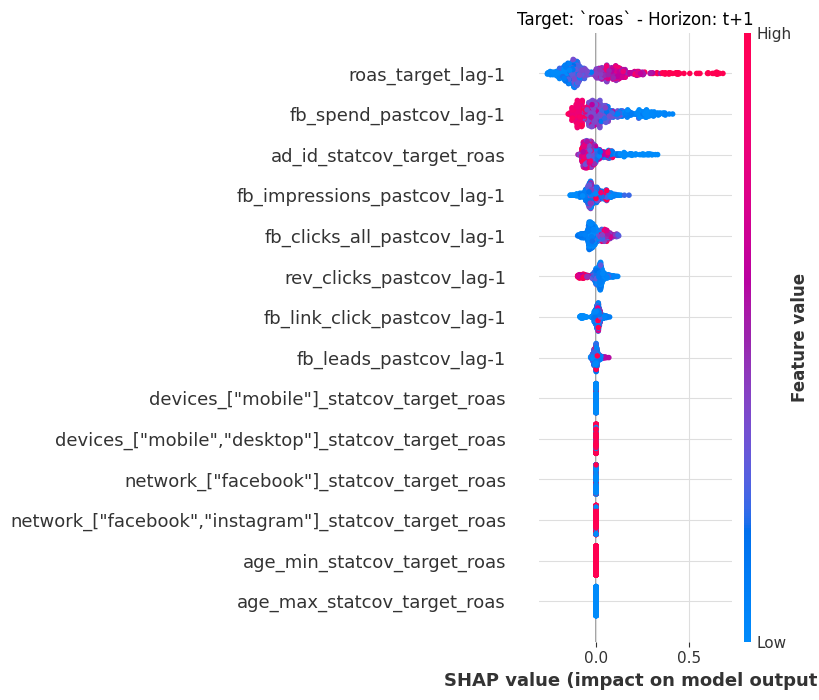

{1: {'roas': .values =
  array([[ 0.12696651,  0.23036091, -0.01377101, ...,  0.        ,
           0.        ,  0.        ],
         [-0.1915146 ,  0.31248105, -0.01649109, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.11875986,  0.29635447, -0.0052156 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.12229053, -0.10364328,  0.00414614, ...,  0.        ,
           0.        ,  0.        ],
         [-0.14484589, -0.09346182, -0.02379531, ...,  0.        ,
           0.        ,  0.        ],
         [-0.12309172,  0.0375565 ,  0.00146221, ...,  0.        ,
           0.        ,  0.        ]])
  
  .base_values =
  array([0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.9197197

In [86]:
shap_explain.summary_plot()

In [85]:
shap_explain.force_plot_from_ts(train_ts[0], past_covariates_ts[0])

In [84]:
shap.initjs()

In [76]:
shap_explain.force_plot_from_ts()

ValueError: Shape of passed values is (803, 14), indices imply (9, 14)

In [74]:
# Assuming ShapExplainer and model are already defined and initialized
shap_explain = ShapExplainer(model, train_ts, past_covariates_ts)

# Generate SHAP values using the explainer
shap_values = shap_explain.explain()

# Check if shap_values is in the correct format (Explanation object)
if isinstance(shap_values, shap.Explanation):
    # If shap_values is an Explanation object, directly pass it to the plot function
    shap.plots.bar(shap_values)
else:
    # If shap_values is not an Explanation object, handle accordingly
    # This part depends on the expected structure of shap_values and how you intend to use it
    print("shap_values is not an Explanation object. Please check the output of shap_explain.explain().")

The model is probabilistic, but num_samples=1 will be used for explainability.


shap_values is not an Explanation object. Please check the output of shap_explain.explain().


In [ ]:
shap_explain shap.plots.bar(shap_values) 

The model is probabilistic, but num_samples=1 will be used for explainability.


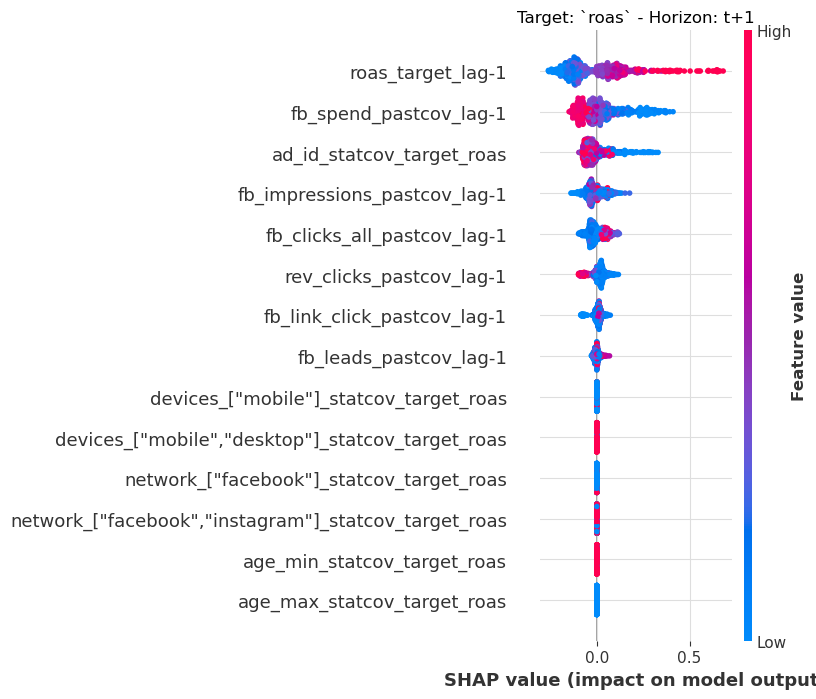

{1: {'roas': .values =
  array([[ 0.12696651,  0.23036091, -0.01377101, ...,  0.        ,
           0.        ,  0.        ],
         [-0.1915146 ,  0.31248105, -0.01649109, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.11875986,  0.29635447, -0.0052156 , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.12229053, -0.10364328,  0.00414614, ...,  0.        ,
           0.        ,  0.        ],
         [-0.14484589, -0.09346182, -0.02379531, ...,  0.        ,
           0.        ,  0.        ],
         [-0.12309172,  0.0375565 ,  0.00146221, ...,  0.        ,
           0.        ,  0.        ]])
  
  .base_values =
  array([0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.91971971, 0.91971971, 0.91971971,
         0.91971971, 0.91971971, 0.9197197

In [226]:
shap_explain = ShapExplainer(model, train_ts, past_covariates_ts,)

results = shap_explain.explain()
# results.plot_shap_values()
shap.plots.bar(shap_values)
shap_explain.summary_plot()
# shap_explain.force_plot_from_ts()

In [214]:
lgbm_forecast

,ad_id,eventdate,roas_actual,roas_forecasted,roas_act_cum,roas_fcst_cum,residuals,model,params
0,120203732424570410,2024-01-18,0.050000,NaN,0.050000,NaN,NaN,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
1,120203732424570410,2024-01-19,0.505155,0.543687,0.555155,0.543687,0.038532,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
2,120203732424570410,2024-01-20,0.865772,0.624844,1.420926,1.168530,-0.240928,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
3,120203732424570410,2024-01-21,0.674877,0.672573,2.095803,1.841104,-0.002303,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
4,120203732424570410,2024-01-22,0.414634,0.622330,2.510437,2.463434,0.207696,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
...,...,...,...,...,...,...,...,...,...
328,120204222484630410,2024-02-02,0.215653,0.425906,1.441625,1.158651,0.210253,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
329,120204222484630410,2024-02-03,0.240505,0.432674,1.682130,1.591325,0.192169,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
330,120204222484630410,2024-02-04,0.277934,0.437710,1.960064,2.029035,0.159776,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
331,120204222484630410,2024-02-05,0.360557,0.395669,2.320621,2.424704,0.035111,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."


In [213]:
lgbm_backtest[1].pd_dataframe()

component,roas
time,
2024-01-19,0.691383
2024-01-20,0.654511
2024-01-21,0.714206
2024-01-22,0.688797
2024-01-23,0.679426
2024-01-24,0.641534


In [202]:
lgbm_forecast.params[0]

{'model_params': {'lags': [-1],
  'output_chunk_length': 1,
  'lags_past_covariates': [-1],
  'likelihood': 'quantile',
  'quantiles': [0.05, 0.5, 0.95],
  'multi_models': True,
  'random_state': 42,
  'use_static_covariates': True,
  'categorical_static_covariates': ['age_max',
   'age_min',
   'network_["facebook","instagram"]',
   'network_["facebook"]',
   'devices_["mobile","desktop"]',
   'devices_["mobile"]']},
 'forecast_params': {'forecast_horizon': 1,
  'predict_likelihood_parameters': False,
  'retrain': False,
  'verbose': False}}

In [201]:
lgbm_forecast.query('ad_id == "120203732424570410"')

,ad_id,eventdate,roas_actual,roas_forecasted,roas_act_cum,roas_fcst_cum,residuals,model,params
0,120203732424570410,2024-01-18,0.050000,NaN,0.050000,NaN,NaN,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
1,120203732424570410,2024-01-19,0.505155,0.543687,0.555155,0.543687,0.038532,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
2,120203732424570410,2024-01-20,0.865772,0.624844,1.420926,1.168530,-0.240928,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
3,120203732424570410,2024-01-21,0.674877,0.672573,2.095803,1.841104,-0.002303,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
4,120203732424570410,2024-01-22,0.414634,0.622330,2.510437,2.463434,0.207696,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
5,120203732424570410,2024-01-23,1.170940,0.487890,3.681378,2.951324,-0.683050,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
6,120203732424570410,2024-01-24,0.273684,1.049043,3.955062,4.000367,0.775359,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
7,120203732424570410,2024-01-25,1.029851,0.684885,4.984913,4.685252,-0.344966,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."


In [169]:
print(model.__class__.__name__)


LightGBMModel


In [136]:
results_df = pd.DataFrame(columns=["event_date", "ad_id", "roas_actual", "roas_forecast", "mae", "experiment_params" ])
empty_df

,event_date,ad_id,roas_actual,roas_forecast,mae,experiment_params


In [146]:
backtest.pd_dataframe().index

DatetimeIndex(['2024-01-27', '2024-01-28', '2024-01-29', '2024-01-30',
               '2024-01-31', '2024-02-01', '2024-02-02'],
              dtype='datetime64[ns]', name='time', freq='D')

In [156]:
from darts.metrics import mae

In [157]:
mae(val_ts[28], backtest)

0.26093642034846937

In [171]:
df = pd.merge(val[val['ad_id'] == "120203979465420410"].sort_values(by='eventdate')[['ad_id', 'eventdate','roas']].rename(columns={'roas': 'roas_actual'}),backtest.pd_dataframe(), left_on='eventdate', right_index=True, how='left').rename(columns={'roas': 'roas_forecasted'}).reset_index(drop=True)
df['roas_act_cum'] = df['roas_actual'].cumsum()
df['roas_fcst_cum'] = df['roas_forecasted'].cumsum()
df['residuals'] = df['roas_forecasted'] - df['roas_actual']
df['model'] = model.__class__.__name__
df['params'] = df.apply(lambda x: {'model_params': model_params, 'forecast_params': forecast_params}, axis=1)


# df.params[0]
df

,ad_id,eventdate,roas_actual,roas_forecasted,roas_act_cum,roas_fcst_cum,residuals,model,params
0,120203979465420410,2024-01-26,0.025362,NaN,0.025362,NaN,NaN,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
1,120203979465420410,2024-01-27,0.493213,0.279213,0.518575,0.279213,-0.214000,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
2,120203979465420410,2024-01-28,1.106542,0.654529,1.625117,0.933741,-0.452013,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
3,120203979465420410,2024-01-29,1.465619,0.911671,3.090736,1.845412,-0.553948,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
4,120203979465420410,2024-01-30,0.720183,0.909390,3.810919,2.754801,0.189206,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
5,120203979465420410,2024-01-31,0.731275,0.777716,4.542194,3.532518,0.046441,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
6,120203979465420410,2024-02-01,0.692909,0.811549,5.235103,4.344067,0.118640,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."
7,120203979465420410,2024-02-02,0.936441,0.684135,6.171544,5.028202,-0.252306,LightGBMModel,"{'model_params': {'lags': [-1], 'output_chunk_..."


In [129]:

val.query('ad_id == "120203979465420410"')

,eventdate,fb_created,campaign_end_date,campaign_duration,buyer_initials,buyer_name,account_currency,account_id,account_name,ad_id,...,age_min,facebook_positions,locales,adset_schedule,lifetime_budget,"network_[""facebook"",""instagram""]","network_[""facebook""]","devices_[""mobile"",""desktop""]","devices_[""mobile""]",fb_created_date
745,2024-01-26,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
746,2024-01-27,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
747,2024-01-28,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
748,2024-01-29,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
749,2024-01-30,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
750,2024-01-31,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
751,2024-02-01,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26
752,2024-02-02,2024-01-26 21:31:56+00:00,2024-02-02,7,GN,Golden Nuggets,USD,7150655894950781,fw84 - FB SCMT 1016 GN (America/Los_Angeles),120203979465420410,...,22,"[""feed"",""biz_disco_feed"",""facebook_reels"",""fac...","[24,6]",NaN,0.0,True,False,True,False,2024-01-26


In [126]:
backtest.pd_series()

time
2024-01-27    0.279213
2024-01-28    0.654529
2024-01-29    0.911671
2024-01-30    0.909390
2024-01-31    0.777716
2024-02-01    0.811549
2024-02-02    0.684135
Freq: D, Name: roas, dtype: float64

In [73]:
model = RegressionModel(
                model=BayesianRidge(),
                lags= list(range(-1, 0)),
                # past_covariates = past_covariates_ts,
                output_chunk_length = 1,
                lags_past_covariates= list(range(-1, 0)),
                # likelihood="quantile", quantiles=[0.05, 0.5, 0.95],                    
                multi_models= True,
                # seed=42,                    
                use_static_covariates = True,   
            )

In [77]:
model.fit(all_campaigns_ts, 
          past_covariates= past_covariates_ts,      
          )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 13
[LightGBM] [Info] Start training from score 0.142091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LightGBMModel(lags=[-1], lags_past_covariates=[-1], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.5, 0.95], random_state=42, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=['age_max', 'age_min', 'network_["facebook","instagram"]', 'network_["facebook"]', 'devices_["mobile","desktop"]', 'devices_["mobile"]'])

In [ ]:
backtest = model.historical_forecasts(
                val_ts, 
                past_covariates_vs,
               #start=0.7, 
               forecast_horizon=1, 
               # stride=3, 
               # num_samples = 50,
               retrain=False, 
               verbose=-1
               )

In [117]:
unique_ad_ids = val['ad_id'].unique()
positions_df = pd.DataFrame({'ad_id': unique_ad_ids, 'position': range(len(unique_ad_ids))})

In [120]:
positions_df.iloc[28].ad_id

'120203979465420410'

In [104]:
## check individual campaign

position = 28

unique_ad_ids = val['ad_id'].unique()
positions_df = pd.DataFrame({'ad_id': unique_ad_ids, 'position': range(len(unique_ad_ids))})
peek(val[val['ad_id'] == positions_df[positions_df['position'] == position]['ad_id'].iloc[0]])

,,,,,,,,,,
0,eventdate,datetime64[ns],2024-01-26 00:00:00,2024-01-27 00:00:00,2024-01-28 00:00:00,2024-01-29 00:00:00,2024-01-30 00:00:00,2024-01-31 00:00:00,2024-02-01 00:00:00,2024-02-02 00:00:00
1,fb_created,object,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00,2024-01-26 21:31:56+00:00
2,campaign_end_date,object,2024-02-02,2024-02-02,2024-02-02,2024-02-02,2024-02-02,2024-02-02,2024-02-02,2024-02-02
3,campaign_duration,int64,7,7,7,7,7,7,7,7
4,buyer_initials,object,GN,GN,GN,GN,GN,GN,GN,GN
5,buyer_name,object,Golden Nuggets,Golden Nuggets,Golden Nuggets,Golden Nuggets,Golden Nuggets,Golden Nuggets,Golden Nuggets,Golden Nuggets
6,account_currency,object,USD,USD,USD,USD,USD,USD,USD,USD
7,account_id,int64,7150655894950781,7150655894950781,7150655894950781,7150655894950781,7150655894950781,7150655894950781,7150655894950781,7150655894950781
8,account_name,object,fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles),fw84 - FB SCMT 1016 GN (America/Los_Angeles)
9,ad_id,object,120203979465420410,120203979465420410,120203979465420410,120203979465420410,120203979465420410,120203979465420410,120203979465420410,120203979465420410


In [107]:
val_ts[28]

<TimeSeries (DataArray) (eventdate: 8, component: 1, sample: 1)>
array([[[0.02536232]],

       [[0.49321267]],

       [[1.10654206]],

       [[1.46561886]],

       [[0.72018349]],

       [[0.73127497]],

       [[0.69290899]],

       [[0.93644068]]])
Coordinates:
  * eventdate  (eventdate) datetime64[ns] 2024-01-26 2024-01-27 ... 2024-02-02
  * component  (component) object 'roas'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  ad_id  age_max  age_min  network_[...
    hierarchy:          None

In [105]:
backtest.pd_dataframe()

component,roas
time,
2024-01-27,0.279213
2024-01-28,0.654529
2024-01-29,0.911671
2024-01-30,0.909390
2024-01-31,0.777716
2024-02-01,0.811549
2024-02-02,0.684135


<Axes: xlabel='eventdate'>

<Axes: xlabel='time'>

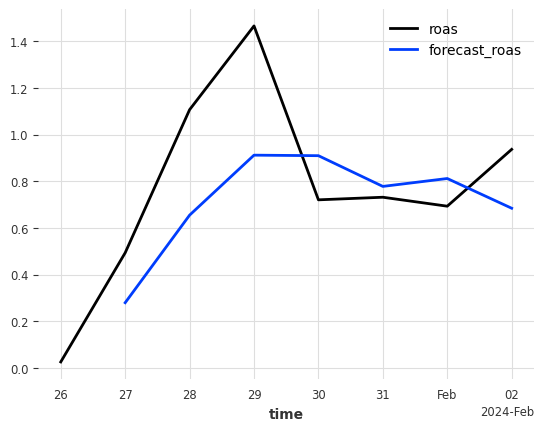

In [103]:
val_index = 28

val_ts[val_index].plot()
backtest = model.historical_forecasts(val_ts[val_index], 
               past_covariates_vs[val_index],
            #    start=0.7, 
               forecast_horizon=1, 
               # stride=3, 
               # num_samples = 50,
               retrain=False, 
               verbose=-1)
backtest.plot(label='forecast_roas')

In [87]:
pd.concat([val_ts[val_index].pd_series(), backtest['roas'].pd_series()], axis=1, keys=['actual', 'forecast'])
df = pd.concat([val_ts[val_index].pd_series(), backtest['roas'].pd_series()], axis=1, keys=['actual', 'forecast'])
# df.loc['2024-01-29':].sum()


,actual,forecast
2024-01-26,0.025362,NaN
2024-01-27,0.493213,0.279213
2024-01-28,1.106542,0.654529
2024-01-29,1.465619,0.911671
2024-01-30,0.720183,0.909390
2024-01-31,0.731275,0.777716
2024-02-01,0.692909,0.811549
2024-02-02,0.936441,0.684135


In [101]:
backtest

<TimeSeries (DataArray) (time: 7, component: 1, sample: 1)>
array([[[0.27921252]],

       [[0.65452861]],

       [[0.91167063]],

       [[0.90938961]],

       [[0.77771623]],

       [[0.81154902]],

       [[0.68413498]]])
Coordinates:
  * time       (time) datetime64[ns] 2024-01-27 2024-01-28 ... 2024-02-02
  * component  (component) object 'roas'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  ad_id  age_max  age_min  network_[...
    hierarchy:          None